In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using Plots
using SparseArrays
using Random
using Test
using StaticArrays
using iLQGameSolver
using BenchmarkTools

┌ Info: Precompiling iLQGameSolver [894a8279-595f-4c20-8f0c-63b9232f715b]
└ @ Base loading.jl:1342
┌ Warning: Package iLQGameSolver does not have SparseArrays in its dependencies:
│ - If you have iLQGameSolver checked out for development and have
│   added SparseArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with iLQGameSolver
└ Loading SparseArrays into iLQGameSolver from project dependency, future warnings for iLQGameSolver are suppressed.


### Quadcopter Nonlinear Dynamics

The states and inputs for the nonlinear quadcopter dynamics are defined as:

$$
\begin{equation}
x = [x, y, z, \dot{x}, \dot{y}, \dot{z}, \phi, \theta, \Psi]^{T} \\
\end{equation}
$$

$$
\begin{equation}
u = [\dot{z}_{cmd}, \phi_{cmd}, \theta_{cmd}, \dot{\Psi}_{cmd}]^{T}
\end{equation}
$$

And the nonlinear system model is defined by:

$$
\begin{equation}
\dot{x} = f(x(t), u(t)) = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \ddot{x} \\
           \ddot{y} \\
           \ddot{z} \\
           \dot{\phi} \\
           \dot{\theta} \\
           \dot{\Psi} \\
         \end{bmatrix} = \begin{bmatrix}
           \dot{x} \\
           \dot{y} \\
           \dot{z} \\
           \frac{sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)cos(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{-sin(\phi)sin(\Psi)+cos(\phi)sin(\theta)sin(\Psi)(\ddot{z}+g)}{cos(\theta)cos(\phi)} \\
           \frac{1}{\tau_{z}} (\dot{z}_{cmd} - \dot{z}) \\
           \frac{1}{\tau_{\phi}} (\phi_{cmd} - \phi) \\
           \frac{1}{\tau{}_{\theta}} (\theta_{cmd} - \theta) \\
           \dot{\Psi}_{cmd} \\
         \end{bmatrix}
\end{equation}
$$


In [3]:
# Setup the problem

dt = 0.1                    # Step size [s]
tf = 20.0                    # Horizon [s]
N = Int(tf/dt)         # Number of steps (knot points)

# Define cost matrices 
nx = 9 
nu = 4
Nplayer = 2

Nu = nu * Nplayer
Nx = nx * Nplayer

Q1 = sparse(zeros(Nx,Nx))     # State cost for agent 1
Q1[1:nx,1:nx] .= 3.0*I(nx)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(Nx,Nx))     # State cost for agent 2
Q2[nx+1:2*nx,nx+1:2*nx] .= 3.0*I(nx)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = sparse(1.0*I(nu))              # Control cost for player 1
R12 = sparse(0.0*I(nu))     # Control cost for player 1 associated with player 2's controls

R21 = sparse(0.0*I(nu))     # Control cost for player 2 associated with player 1's controls
R22 = sparse(1.0*I(nu))              # Contorl cost for player 2


dmax = 2.0                  # Distance that both agents should keep between each other [m]
ρ = 500.0                   # Penalty factor for violating the distance constraint

# Q's are stacked vertically
Q = sparse(zeros(Float32, Nx*Nplayer, Nx))
# @show size([Q1; Q2; Q3]), size(Q)
#Q .= [Q1; Q2]
Q .= [Q1; Q2]

# Qn's are stacked vertically
Qn = sparse(zeros(Float32, Nx*Nplayer, Nx))
#Qn .= [Qn1; Qn2]
Qn .= [Qn1; Qn2]

# R's are stacked as a matrix
R = sparse(zeros(Float32, Nu, Nu))
#R .= [R11 R12; R21 R22]
R .= [R11 R12; R21 R22]

NHor = 25
tol = 1e-2

game = iLQGameSolver.GameSetup(nx, nu, Nplayer, Q, R, Qn, dt, tf, NHor, dmax, ρ, tol)

solver = iLQGameSolver.iLQSetup(Nx, Nu, Nplayer, NHor)

solver.P = ones(NHor, Nu, Nx)*0.001
solver.α = ones(NHor, Nu)*0.001;

In [4]:
# Initial and final states

x₀= [5.0; 5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 
    -5.0; -5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0]        # Initial state

xgoal = [  -5.0; -5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 
            5.0; 5.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0];  # Final state

# Input constraints
umax = [10.0, pi, pi, pi, 
        10.0, pi, pi, pi]   

umin = [-10.0, -pi, -pi, -pi, 
        -10.0, -pi, -pi, -pi] 

ugoal = [0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0]     

game.x0 .= x₀
game.xf .= xgoal
game.umin .= umin
game.umax .= umax
game.uf .= ugoal;

In [5]:
X, U = iLQGameSolver.recedingHorizon(game, solver, iLQGameSolver.quadcopter, iLQGameSolver.costQuadcopter);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [6]:
X[end,:,:]

18×1 Matrix{Float64}:
 -4.984318574301309
 -5.4438000907619255
 -5.073417617249447e-6
  0.00022619588182258693
 -0.007651665165968571
 -3.5234185508249444e-7
 -0.006408845070707738
  2.6738807138760546e-6
  0.007760584732800718
  4.984318470674417
  5.443801456098733
 -5.073348681430843e-6
 -0.00022620250126570744
  0.0076517988551595
 -3.5232021327333494e-7
  0.006408913578329497
 -2.6735382947362293e-6
  0.00776068359727754

In [7]:
xend = X[end,:,:]

@test xend[1] ≈ xgoal[1] atol=1e-1 
@test xend[2] ≈ xgoal[2] atol=1e0 
@test xend[3] ≈ xgoal[3] atol=1e-1 
@test xend[4] ≈ xgoal[4] atol=1e-1 
@test xend[5] ≈ xgoal[5] atol=1e-1 
@test xend[6] ≈ xgoal[6] atol=1e-1 
@test xend[7] ≈ xgoal[7] atol=1e-1 
@test xend[8] ≈ xgoal[8] atol=1e-1 
@test xend[9] ≈ xgoal[9] atol=1e0 
@test xend[10] ≈ xgoal[10] atol=1e-1 
@test xend[11] ≈ xgoal[11] atol=1e0 
@test xend[12] ≈ xgoal[12] atol=1e-1 

Test Passed

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/quadcopter.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/quadcopter.gif")
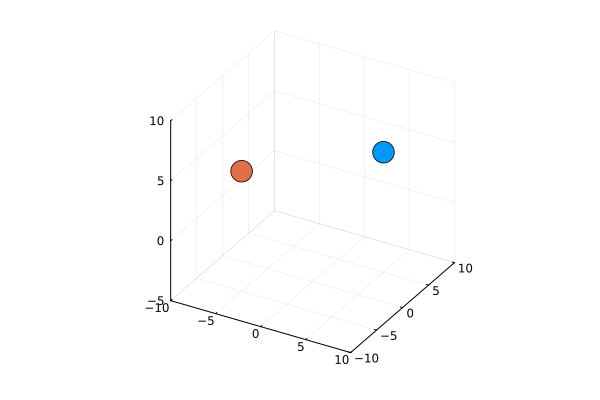

In [8]:
anim = @animate for t in 1:N
    scatter3d([X[t,1,:]], [X[t,2,:]], [X[t,3,:]], m = (:circle, 12),
    xlims = (-10, 10), 
    ylims = (-10, 10), 
    zlims = (-5, 10),
    legend = false)
    scatter3d!([X[t,10,:]], [X[t,11,:]], [X[t,12,:]], m = (:circle, 12))
end every 1;
gif(anim, "assets/quadcopter.gif")

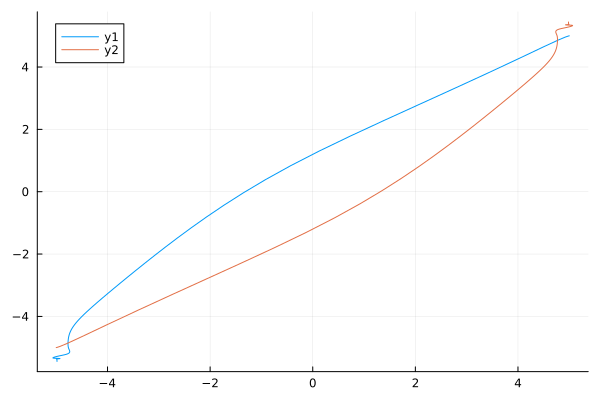

In [9]:
plot(X[:,1], X[:,2])
plot!(X[:,10], X[:,11])


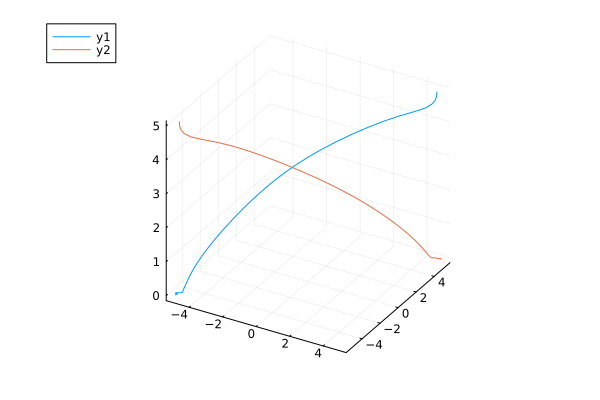

In [10]:
plot3d(X[:,1], X[:,2], X[:,3])
plot3d!(X[:,10], X[:,11], X[:,12])

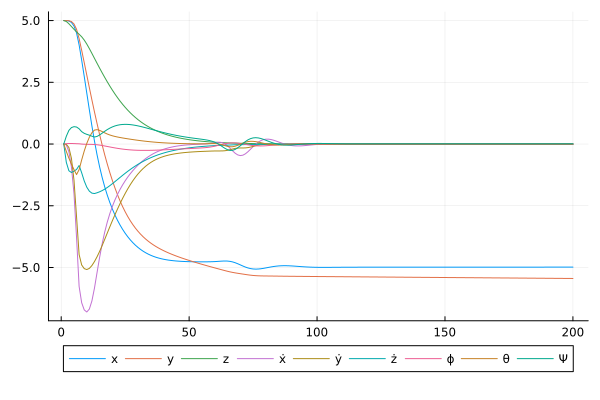

In [11]:
# Plot of all states for agent 1

plot([X[:,1:9]], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)

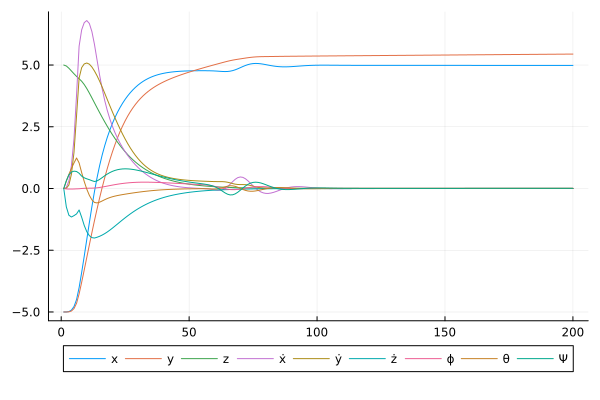

In [12]:
# Plot of all states for agent 2

plot([X[:,10:18]], 
    label=["x" "y" "z" "ẋ" "ẏ" "ż" "ϕ" "θ" "Ψ"],
    legend=:outerbottom, 
    legendcolumns=9)